In [22]:
import ale_py
import shimmy
import random
import numpy as np
import torch
import gymnasium as gym
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from gymnasium.wrappers import AtariPreprocessing


In [23]:
# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Create MsPacman environment
env = gym.make("ALE/MsPacman-v5", render_mode='rgb_array', frameskip=1)
env = AtariPreprocessing(env, frame_skip=4)


(84, 84)
(210, 160, 3)


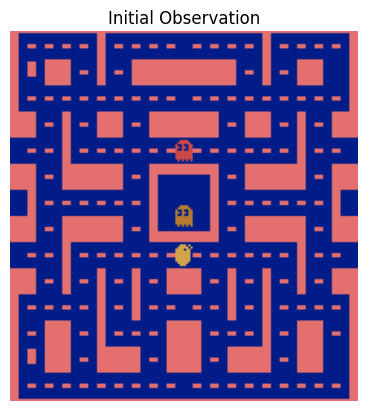

In [24]:
import matplotlib.pyplot as plt

# Reset the environment to get the initial state
obs, info = env.reset()
print(obs.shape)

# Render as RGB array
frame = env.render()
print(frame.shape)
# Show the image
plt.imshow(frame[1:171])
plt.axis('off')
plt.title("Initial Observation")
plt.show()


In [25]:
print("Action space:", env.action_space)
print("Number of actions:", env.action_space.n)


Action space: Discrete(9)
Number of actions: 9


In [26]:
valid_actions = [1,2,3,4] # Just Up, Right, Down, Left

## Preprocessing

In [27]:
def preprocess(obs):
    """
    Preprocess observation:
      - Crop the frame: use obs[1:171] to remove the top row and bottom HUD parts.
      - Convert to grayscale.
      - Resize to 84x84.
      - Normalize pixel values to [0, 1].
      
    Parameters:
        obs (np.array): The raw observation from the environment.
        
    Returns:
        processed (np.array): Processed frame of shape (84, 84).
    """
    # Crop the image (rows 1 to 170)
    cropped = obs[1:171]  # Note: shape changes from (210,160,3) -> (170,160,3)
    img = Image.fromarray(cropped)
    img = img.convert("L")        # convert to grayscale
    img = img.resize((84, 84))    # resize as in DQN paper
    processed = np.array(img, dtype=np.float32)
    processed /= 255.0            # normalize pixels
    return processed


## Deep Convolutional NN

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class DQN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super(DQN, self).__init__()
        
        # First convolutional layer: 32 filters, 8x8 kernel, stride 4.
        self.conv1 = nn.Conv2d(in_channels=input_channels, out_channels=32, kernel_size=8, stride=4)
        
        # Second convolutional layer: 64 filters, 4x4 kernel, stride 2.
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)
        
        # Third convolutional layer: 64 filters, 3x3 kernel, stride 1.
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
        
        # Compute the size of the output from the convolutional layers.
        # This will be used as input size for the fully connected layer.
        conv_out_size = self._get_conv_out((input_channels, 84, 84))
        
        # Fully connected layer with 512 units.
        self.fc1 = nn.Linear(conv_out_size, 512)
        
        # Output layer: one linear unit per valid action.
        self.out = nn.Linear(512, num_actions)
    
    def _get_conv_out(self, shape):
        # Create a dummy tensor with batch size 1.
        o = torch.zeros(1, *shape)
        o = F.relu(self.conv1(o))
        o = F.relu(self.conv2(o))
        o = F.relu(self.conv3(o))
        # Flatten: compute the total number of elements.
        return int(np.prod(o.size()))
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # Flatten the output for the fully connected layer.
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.out(x)


## Replay Buffer

In [29]:
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    
    def __len__(self):
        return len(self.buffer)


## Training

In [30]:
valid_actions = [1,2,3,4]

In [31]:
batch_size = 32
gamma = 0.99
lr = 1e-4
target_update_interval = 1000  # update target network every 1000 frames

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For a single preprocessed frame, we use 1 channel and an 84x84 image.
input_shape = (1, 84, 84)
num_actions = len(valid_actions)

# Initialize policy network and target network
policy_net = DQN(input_shape[0], num_actions).to(device)
target_net = DQN(input_shape[0], num_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
replay_buffer = ReplayBuffer(10000)

def epsilon_by_frame(frame_idx, num_frames):
    # Linearly anneal from 1.0 to 0.1 over frames, then fix at 0.1.
    if frame_idx < num_frames:
        return 1.0 - 0.2 * (frame_idx / num_frames)
    else:
        return 0.1


def clip_reward(reward):
    if reward > 0:
        return 1
    elif reward < 0:
        return -1
    else:
        return 0


num_episodes = 600  # Adjust as needed
frame_idx = 0

for episode in range(num_episodes):
    # Reset environment and preprocess initial observation
    raw_obs, _ = env.reset()
    # Skip first 66 frames as no action (game initialization)
    for j in range(66):
        raw_obs, _, _, _, _ = env.step(0)
    processed_frame = preprocess(raw_obs)             # shape: (84,84)
    state = np.expand_dims(processed_frame, axis=0)     # add channel dimension: (1,84,84)
    
    
    # plt.imshow(processed_frame)
    # plt.title(f"Initial Frame")
    # plt.axis("off")
    # display(plt.gcf())

    episode_reward = 0
    done = False
    while not done:
        # Select action using ε-greedy policy
        epsilon = epsilon_by_frame(frame_idx, num_episodes)
        if random.random() > epsilon:
            # Use the model: need to add a batch dimension (1, 1, 84, 84)
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            q_values = policy_net(state_tensor)
            action_idx = q_values.max(1)[1].item()
        else:
            action_idx = random.randrange(num_actions)
        
        # Map the chosen index to the actual environment action
        action = valid_actions[action_idx]
        
        # Execute the action in the environment
        next_raw_obs, reward, terminated, truncated, info = env.step(action)
        # if random.random() < 0.05:
        #     plt.imshow(preprocess(next_raw_obs))
        #     plt.title(f"Played action: {action}, obtained reward: {reward}")
        #     plt.axis("off")
        #     display(plt.gcf())
        reward = clip_reward(reward)
        done = terminated or truncated
        episode_reward += reward
        
        # Preprocess next observation
        processed_next_frame = preprocess(next_raw_obs)
        next_state = np.expand_dims(processed_next_frame, axis=0)  # shape: (1,84,84)
        
        # Store transition in replay memory
        replay_buffer.push(state, action_idx, reward, next_state, done)
        
        state = next_state  # Move to next state
        frame_idx += 1
        
        # Update policy network if enough samples are available
        if len(replay_buffer) > batch_size:
            transitions = replay_buffer.sample(batch_size)
            batch_state = torch.FloatTensor(np.stack(transitions.state)).to(device)       # shape: (batch, 1,84,84)
            batch_action = torch.LongTensor(transitions.action).unsqueeze(1).to(device)
            batch_reward = torch.FloatTensor(transitions.reward).unsqueeze(1).to(device)
            batch_next_state = torch.FloatTensor(np.stack(transitions.next_state)).to(device)
            batch_done = torch.FloatTensor(transitions.done).unsqueeze(1).to(device)
            
            # Compute current Q-values from policy_net
            current_q = policy_net(batch_state).gather(1, batch_action)
            
            # Compute target Q-values from target_net
            with torch.no_grad():
                max_next_q = target_net(batch_next_state).max(1)[0].unsqueeze(1)
                expected_q = batch_reward + gamma * max_next_q * (1 - batch_done)
            
            # Compute loss and update the policy network
            loss = nn.MSELoss()(current_q, expected_q)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        # Periodically update the target network with policy network weights
        if frame_idx % target_update_interval == 0:
            target_net.load_state_dict(policy_net.state_dict())
    
    print(f"Episode: {episode} | Reward: {episode_reward:.2f} | Epsilon: {epsilon:.3f}")

env.close()


Episode: 0 | Reward: 17.00 | Epsilon: 0.868


KeyboardInterrupt: 

In [32]:
# Save full models
torch.save(policy_net, "dqn_policy_full.pt")
torch.save(target_net, "dqn_target_full.pt")


## Evaluation

In [33]:
from torch.serialization import add_safe_globals
add_safe_globals([DQN])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Then load
policy_net = torch.load("dqn_policy_full.pt", map_location=device, weights_only=False)
target_net = torch.load("dqn_target_full.pt", map_location=device, weights_only=False)

policy_net.eval()
target_net.eval()



DQN(
  (conv1): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=4, bias=True)
)

In [34]:
valid_actions = [1,2,3,4]

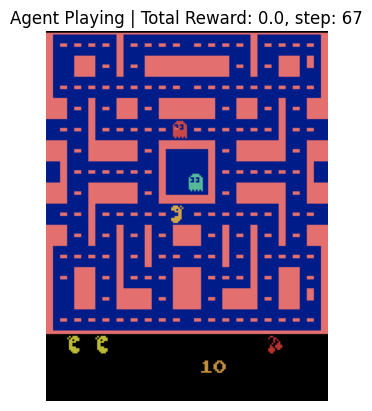

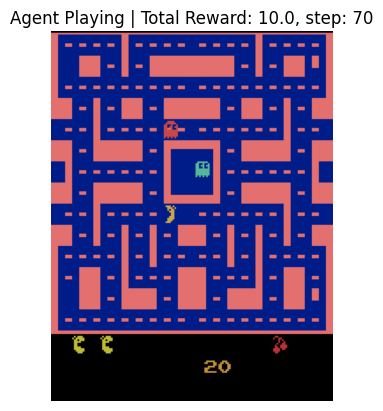

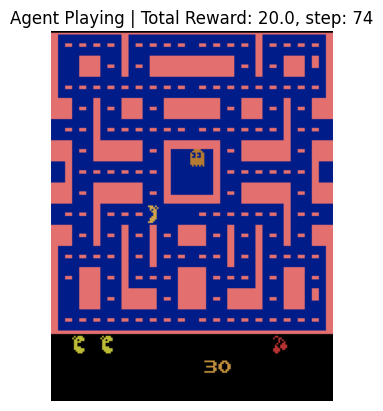

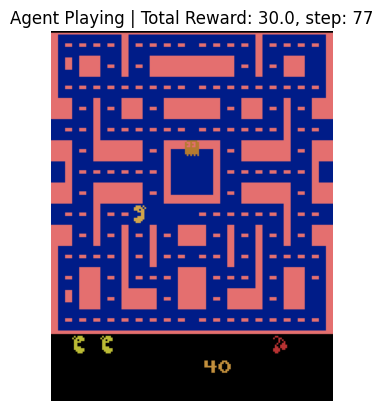

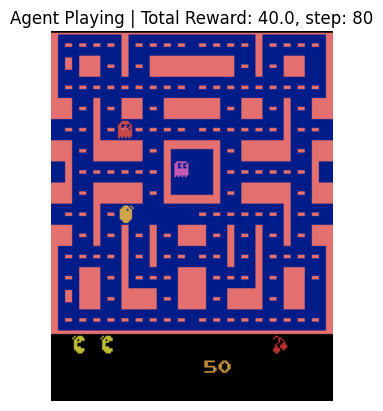

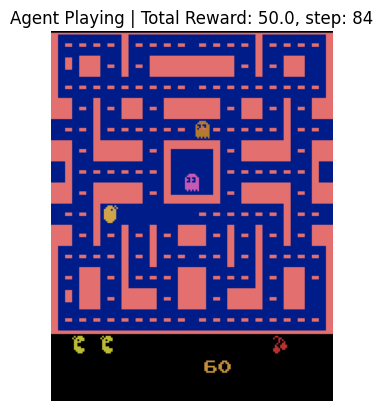

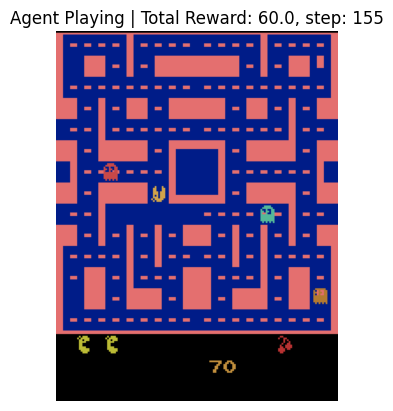

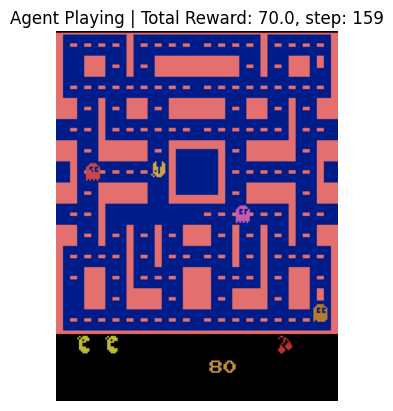

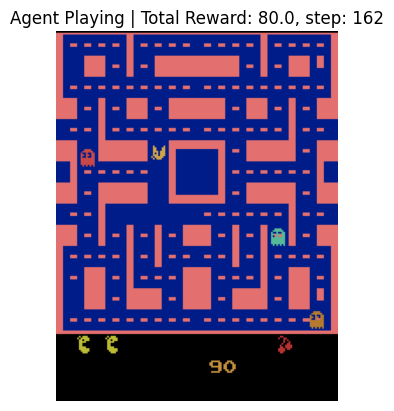

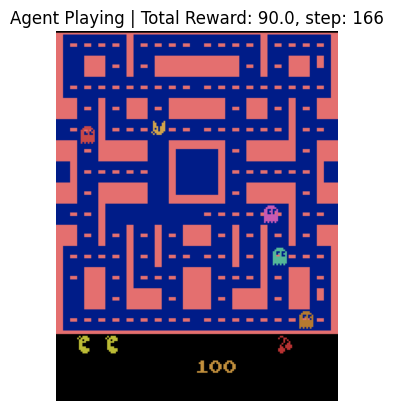

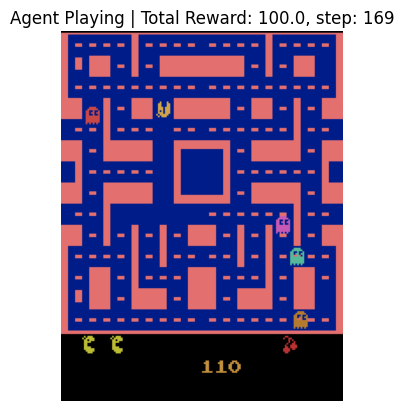

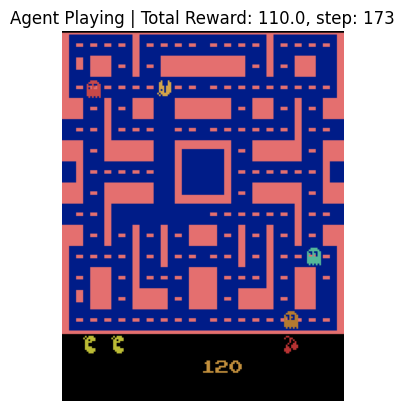

Episode finished with total reward: 120.0


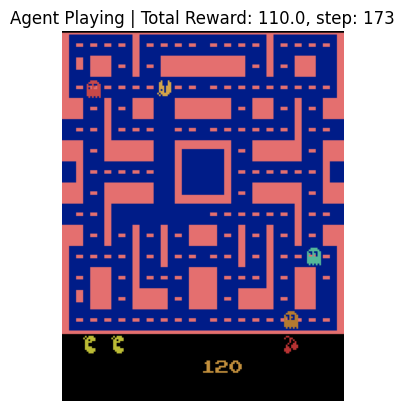

In [35]:
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output

def evaluate_agent(env, policy_net, valid_actions, delay=0.1):
    # Reset the environment
    raw_obs, _ = env.reset()
    processed_frame = preprocess(raw_obs)              
    state = np.expand_dims(processed_frame, axis=0)     
    done = False
    total_reward = 0
    
    policy_net.eval()  
    
    frames = []
    i = 0
    while not done:
        
        
        i += 1
        # Choose action greedily (epsilon=0)
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)  # shape: (1,1,84,84)
        with torch.no_grad():
            q_values = policy_net(state_tensor)
        action_idx = q_values.max(1)[1].item()   #
        action = valid_actions[action_idx]

        # print(f"Action idx: {action_idx}, Action: {action}")


        # Step the environment
        next_raw_obs, reward, terminated, truncated, info = env.step(action)

        # print(f"Played action: {action}, got reward: {reward}")
        frame = env.render()
        if reward != 0:
            plt.imshow(frame)
            plt.title(f"Agent Playing | Total Reward: {total_reward}, step: {i}")
            plt.axis("off")
            display(plt.gcf())
            # clear_output(wait=True)
            # time.sleep(delay)

        total_reward += reward
        done = terminated or truncated
        
        # Preprocess next observation and update state
        processed_next_frame = preprocess(next_raw_obs)
        state = np.expand_dims(processed_next_frame, axis=0)
    
    print(f"Episode finished with total reward: {total_reward}")

env.reset()
evaluate_agent(env, policy_net, valid_actions, delay=0.1)
